In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from math import pow

In [209]:
mi= 0.015
CN=10
n=2
D_aTc=0.67*60
D_ahl=100
Nmin=0.129*10**(7)
Nmax=2.142*10**(7)
Vecoli=10**(-15)
Vbead=200*10**(-6)
Vc=Vecoli/Vbead
d_aTc=0.034/60
d_mrnatetr=0.023*60
d_tetr=0.0692
d_ahl=0.01
d_mrnaluxi=0.347
d_luxi=0.00167
d_cmplx=0.025
kluxi=3.95*60 #*10**(-3) #FOR BCD2
kA= 0.04 
NA=6.2*10**(23)
k_min_one=4.2*10**(-4)
kd_cmplx=15  
kd_ptet=50 
k1=k_min_one/kd_cmplx
b_ptet=0
ptet=22*60*10**(-3)
p_105=30*60*10**(-3)
k_034=11*60*10**(-3)
t=np.linspace(0, 1000)

In [210]:
def single_cell(x,t): 
    aTc=x[0]
    TetR=x[1]
    cmplx=x[2]
    LuxI=x[3]
    ahl=x[4]
    
    daTcdt=small+k_min_one*cmplx-(d_aTc+mi)*aTc-k1*aTc*TetR
    dTetRdt=small+molar(p_105*k_034*CN/(d_mrnatetr+mi))+k_min_one*cmplx-k1*TetR*aTc-(d_tetr+mi)*TetR
    dcmplxdt=small+k1*TetR*aTc-k_min_one*cmplx-(d_cmplx+mi)*cmplx
    dLuxIdt=small+(ptet*kluxi*CN/(d_mrnaluxi+mi))*(b_ptet+(1-b_ptet)*((pow(abs(cmplx),n))/((pow(abs(cmplx),n))+(pow(kd_ptet*CN,n))))) - (d_luxi+mi)*LuxI -kA*LuxI
    dAHLdt=small+kA*LuxI-(d_ahl+mi)*ahl
    
    return [daTcdt,dTetRdt,dcmplxdt,dLuxIdt,dAHLdt]

def whole_cell(x,t): 
    N_a=x[0]
    aTc_ext=x[1]
    aTc_int=x[2]
    TetR=x[3]
    cmplx=x[4]
    LuxI=x[5]
    AHL_int=x[6]
    AHL_ext=x[7]
    
    dNdt=small+mi*N_a*(1-(N_a/Nmax))
    daTc_extdt=small+ Vc*D_aTc*N_a*(aTc_int-aTc_ext)-(d_aTc+mi)*aTc_ext
    daTc_intdt=small+ D_aTc*Vc*10**(11)*(aTc_ext-aTc_int)+k_min_one*cmplx-(d_aTc+mi)*aTc_int-k1*aTc_int*TetR
    dTetRdt=small+molar(p_105*k_034*CN/(d_mrnatetr+mi))+k_min_one*cmplx-k1*TetR*aTc_int-(d_tetr+mi)*TetR
    dcmplxdt=small+k1*TetR*aTc_int-k_min_one*cmplx-(d_cmplx+mi)*cmplx
    dLuxIdt=small+(ptet*kluxi*CN/(d_mrnaluxi+mi))*(b_ptet+(1-b_ptet)*((pow(abs(cmplx),n))/((pow(abs(cmplx),n))+(pow(kd_ptet*CN,n))))) - (d_luxi+mi)*LuxI -kA*LuxI
    dAHL_intdt=small+kA*LuxI-(d_ahl+mi)*AHL_int+D_ahl*(Vc*AHL_ext-AHL_int)
    dAHL_extdt=small+D_ahl*N_a*(AHL_int-Vc*AHL_ext)-(d_ahl+mi)*AHL_ext

    return [dNdt,daTc_extdt,daTc_intdt,dTetRdt,dcmplxdt,dLuxIdt,dAHL_intdt,dAHL_extdt]

def molecules(number): #turns nM to molecules
    return number*NA*10**(-12)

def molar(number): #turns molecules to M
    return(number*10**(15))/NA

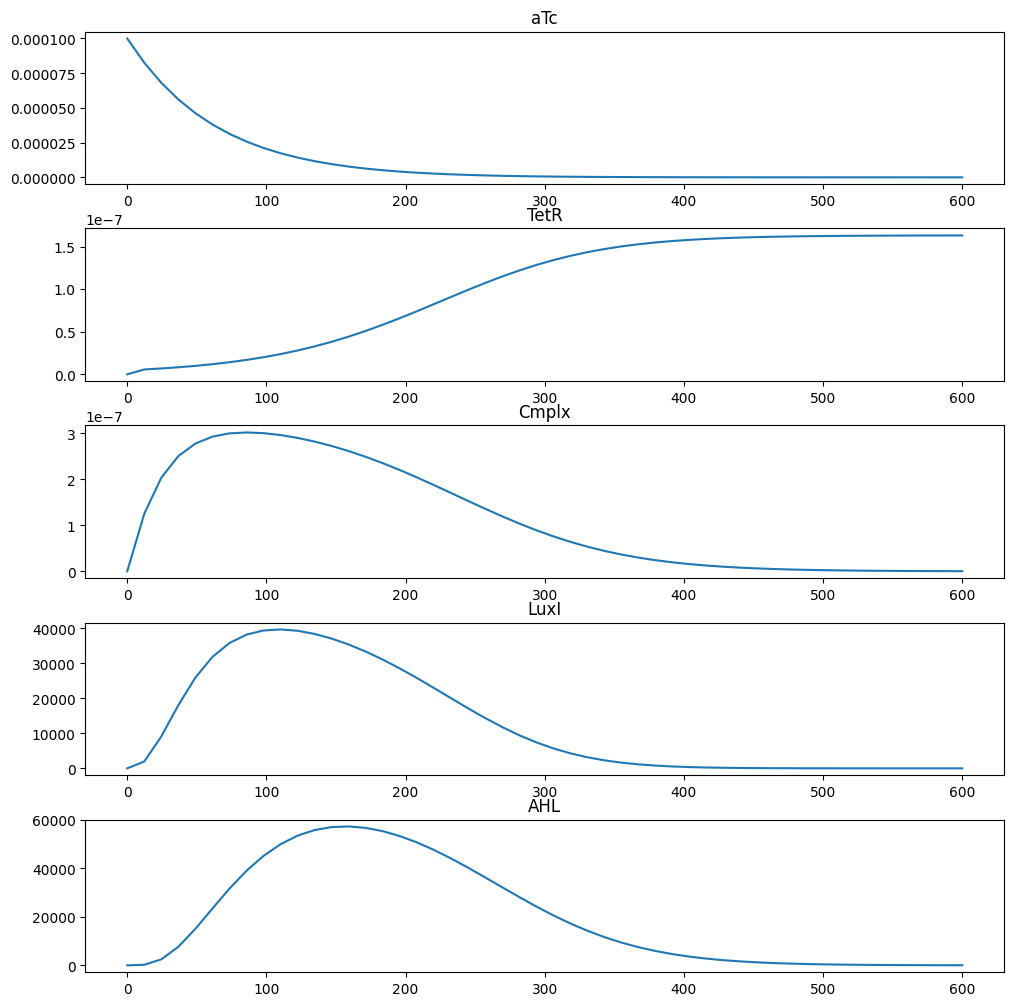

In [225]:
#Time-Scale Single Cell(aTc in Molar)
t=np.linspace(0, 600)
small=0
n=2
kd_cmplx=15*10**(-9)
kd_ptet=50*10**(-9)
k1=k_min_one/kd_cmplx
x0=[10**(-4),0,0,0,0] #aTc-TetR-cmplx-LuxI-AHL
solution=odeint(single_cell,x0,t)
fig,axs=plt.subplots(5,figsize=(10,10))
fig.tight_layout()
axs[0].plot(t,solution[:,0])
axs[0].set_title('aTc')
axs[1].plot(t,solution[:,1])
axs[1].set_title('TetR')
axs[2].plot(t,solution[:,2])
axs[2].set_title('Cmplx')
axs[3].plot(t,solution[:,3])
axs[3].set_title('LuxI')
axs[4].plot(t,solution[:,4])
axs[4].set_title('AHL')
ahl_for_fit=molar(solution[:,4])

Text(0.5, 1.0, 'AHL_ext')

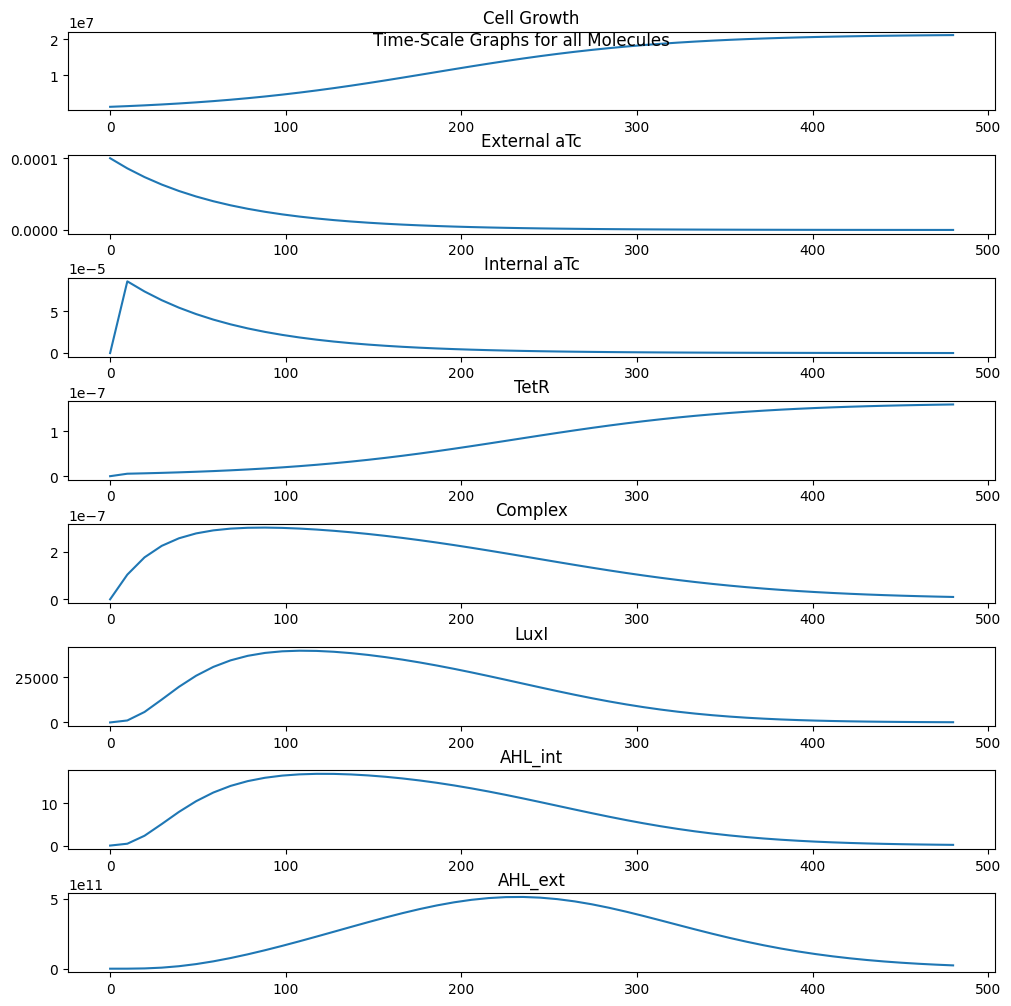

In [224]:
#Time-Scale Whole Cell(aTc in Molar)
small=0
n=2
t=np.linspace(0,480,50)
kd_cmplx=15*10**(-9)
kd_ptet=50*10**(-9)
k1=k_min_one/kd_cmplx
x0=[Nmin,10**(-4),0,0,0,0,0,0] #N-aTc_ext-aTc_int-TetR-LuxI-AHL_int-AHL_ext
solution=odeint(whole_cell,x0,t)
fig,axs=plt.subplots(8,figsize=(10,10))
fig.tight_layout()
plt.suptitle('Time-Scale Graphs for all Molecules')
axs[0].plot(t,solution[:,0])
axs[0].set_title('Cell Growth')
axs[1].plot(t,solution[:,1])
axs[1].set_title('External aTc')
axs[2].plot(t,solution[:,2])
axs[2].set_title('Internal aTc')
axs[3].plot(t,solution[:,3])
axs[3].set_title('TetR')
axs[4].plot(t,solution[:,4])
axs[4].set_title('Complex')
axs[5].plot(t,solution[:,5])
axs[5].set_title('LuxI')
axs[6].plot(t,solution[:,6])
axs[6].set_title('AHL_int')
axs[7].plot(t,solution[:,7])
axs[7].set_title('AHL_ext')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


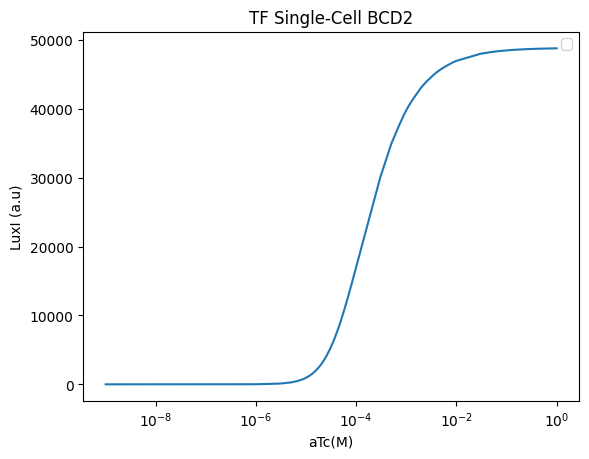

In [234]:
small=0
n=2
kd_cmplx=150*10**(-9)
kd_ptet=50*10**(-9)
k1=k_min_one/kd_cmplx
aTc_values_0=np.linspace(10**(-9),10**(-6))
aTc_values_1=np.linspace(10**(-6),10**(-4))
aTc_values_2=np.linspace(10**(-4),10**(-2))
aTc_values_3=np.linspace(10**(-2),10**(0))
aTc_values=np.concatenate([aTc_values_0,aTc_values_1,aTc_values_2,aTc_values_3])
AHL_temp=[]
for i in range(int(np.shape(aTc_values)[0])):
    x0=[aTc_values[i],0,0,0,0] #LuxR-Mon-Dim-mng
    solution=odeint(single_cell,x0,t)
    AHL_temp.append(max(solution[:,3]))
plt.semilogx(aTc_values,AHL_temp)
plt.xlabel('aTc(M)')
plt.ylabel('LuxI (a.u)')
plt.title('TF Single-Cell BCD2')
plt.legend()
plt.show()

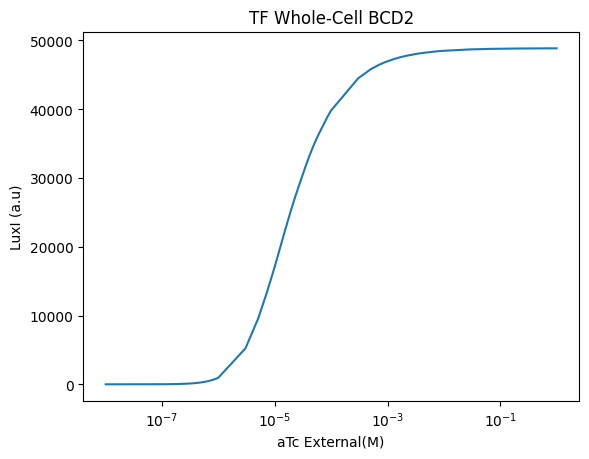

In [235]:
small=1e-45
n=2
kd_cmplx=15*10**(-9)
kd_ptet=50*10**(-9)
k1=k_min_one/kd_cmplx
aTc_values_0=np.linspace(10**(-8),10**(-6))
aTc_values_1=np.linspace(10**(-6),10**(-4))
aTc_values_2=np.linspace(10**(-4),10**(-2))
aTc_values_3=np.linspace(10**(-2),10**(0))
aTc_values=np.concatenate([aTc_values_0,aTc_values_1,aTc_values_2,aTc_values_3])
AHL_temp=[]
for i in range(int(np.shape(aTc_values)[0])):
    x0=[Nmin,aTc_values[i],0,0,0,0,0,0] #LuxR-Mon-Dim-mng
    solution=odeint(whole_cell,x0,t)
    AHL_temp.append(max(solution[:,5]))
plt.semilogx(aTc_values,AHL_temp)
plt.xlabel('aTc External(M)')
plt.ylabel('LuxI (a.u)')
plt.title('TF Whole-Cell BCD2')
plt.show()

In [215]:
#model_fit_functions
def f(x,t,paras):
    N_a=x[0]
    aTc_ext=x[1]
    aTc_int=x[2]
    TetR=x[3]
    cmplx=x[4]
    LuxI=x[5]
    AHL_int=x[6]
    AHL_ext=x[7]
    
    try:
        mi = paras['mi'].value
        a_tetr = paras['a_tetr'].value
        b_ptet=paras['b_ptet'].value
        a_luxi = paras['a_luxi'].value
        kd_ptet=paras['kd_ptet'].value
        n = paras['n'].value


    except KeyError:
        mi,a_tetr,b_ptet,a_luxi,kd_ptet,n = paras

    dNdt=small+mi*N_a*(1-(N_a/Nmax))
    daTc_extdt=small+ Vc*D_aTc*N_a*(aTc_int-aTc_ext)-(d_aTc+mi)*aTc_ext
    daTc_intdt=small+ D_aTc*Vc*10**(11)*(aTc_ext-aTc_int)+k_min_one*cmplx-(d_aTc+mi)*aTc_int-k1*aTc_int*TetR
    dTetRdt=small+molar(a_tetr*CN/(d_mrnatetr+mi))+k_min_one*cmplx-k1*TetR*aTc_int-(d_tetr+mi)*TetR
    dcmplxdt=small+k1*TetR*aTc_int-k_min_one*cmplx-(d_cmplx+mi)*cmplx
    dLuxIdt=small+(a_luxi*CN/(d_mrnaluxi+mi))*(b_ptet+(1-b_ptet)*((pow(abs(cmplx),n))/((pow(abs(cmplx),n))+(pow(kd_ptet*CN,n))))) - (d_luxi+mi)*LuxI -kA*LuxI
    dAHL_intdt=small+kA*LuxI-(d_ahl+mi)*AHL_int+D_ahl*(Vc*AHL_ext-AHL_int)
    dAHL_extdt=small+D_ahl*N_a*(AHL_int-Vc*AHL_ext)-(d_ahl+mi)*AHL_ext
    
    return [dNdt,daTc_extdt,daTc_intdt,dTetRdt,dcmplxdt,dLuxIdt,dAHL_intdt,dAHL_extdt]

def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):
    luxi_model=[]
    for i in range(len(x0_measured)):
        x0=[Nmin,x0_measured[i],0,0,0,0,0,0]
        model = g(t, x0, paras)
        luxi_model.append(max(model[:,5]))
    luxi_model=np.array(luxi_model)
    print(luxi_model)
    print(data)
    data=np.array(data)
    print( paras['mi'].value,paras['a_tetr'].value,paras['b_ptet'].value,paras['a_luxi'].value,paras['kd_ptet'].value,paras['n'].value)
    return (luxi_model-data).ravel()


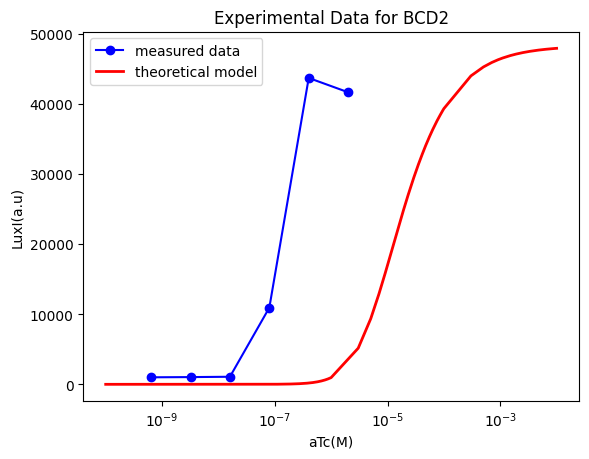

In [232]:
t_measured=[0,30,60,90,120,150,180,210,240]
x5_measured=[1001,1031,1079,10937,43704,41664]
x0_measured=np.array([6.4,32,160,800,4000,20000])*10**(-10)
small=0

kd_cmplx=15*10**(-9)
kd_ptet=50*10**(-9)
k1=k_min_one/kd_cmplx

plt.figure()
plt.semilogx(x0_measured, x5_measured, marker='o', color='b', label='measured data')
plt.xlabel('aTc(M)')
plt.ylabel('LuxI(a.u)')
plt.title('Experimental Data for BCD2')

params=Parameters()
params.add('mi', value=0.015, min=0, max=1)
params.add('a_tetr',value=1.18, min=0,max=1000)
params.add('b_ptet', value=0, min=0, max=1)
params.add('a_luxi', value=312, min=0, max=1000)
params.add('kd_ptet', value=50*10**(-9), min=10**(-18), max=1)
params.add('n', value=2, min=0.25, max=4)

aTc_values_0=np.linspace(10**(-10),10**(-8))
aTc_values_1=np.linspace(10**(-8),10**(-6))
aTc_values_2=np.linspace(10**(-6),10**(-4))
aTc_values_3=np.linspace(10**(-4),10**(-2))
aTc_values=np.concatenate([aTc_values_0,aTc_values_1,aTc_values_2,aTc_values_3])

luxi_fit=[]

for i in range(200):
    y0=[Nmin,aTc_values[i],0,0,0,0,0,0]
    model=g(np.linspace(0,360,100),y0,params)
    luxi_fit.append(max(model[:,5]))

plt.semilogx(aTc_values, luxi_fit,linewidth=2,color='red',label='theoretical model')
plt.legend()
plt.show()



In [ ]:
#result = minimize(residual, params, args=(t_measured, x5_measured),method='Nelder-Mead', tol=1e-6) #doesnt stop
#print(result.params)

C:\Users\manos\AppData\Local\Temp\ipykernel_18788\879871445.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g^" (-> marker='^'). The keyword argument will take precedence.
  plt.semilogx(x0_measured, x5_measured,'g^', marker='o', color='b', label='measured data')
C:\Users\manos\AppData\Local\Temp\ipykernel_18788\879871445.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g^" (-> color='g'). The keyword argument will take precedence.
  plt.semilogx(x0_measured, x5_measured,'g^', marker='o', color='b', label='measured data')


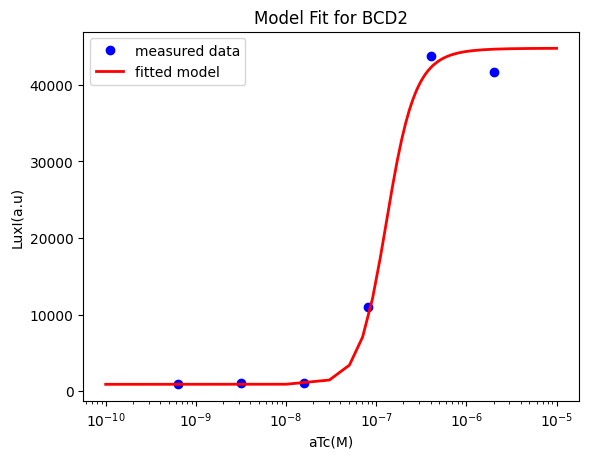

Molecules (10^12) produced at maximum Induction from BCD: 1.249873690722086


In [233]:
params['mi'].value=0.014
params['a_tetr'].value=0.93
params['b_ptet'].value=0.02
params['a_luxi'].value=90
params['kd_ptet'].value=5*10**(-10)
params['n'].value=3



plt.figure()
plt.semilogx(x0_measured, x5_measured,'g^', marker='o', color='b', label='measured data')
plt.xlabel('aTc(M)')
plt.ylabel('LuxI(a.u)')
plt.title('Model Fit for BCD2')

aTc_values_0=np.linspace(10**(-10),10**(-9))
aTc_values_1=np.linspace(10**(-9),10**(-8))
aTc_values_2=np.linspace(10**(-8),10**(-6))
aTc_values_3=np.linspace(10**(-6),10**(-5))
aTc_values=np.concatenate([aTc_values_0,aTc_values_1,aTc_values_2,aTc_values_3])

luxi_fit=[]


for i in range(200):
    y0=[Nmin,aTc_values[i],0,0,0,0,0,0]
    model_fit=g(np.linspace(0,360,100),y0,params)
    luxi_fit.append(max(model_fit[:,5]))

plt.semilogx(aTc_values, luxi_fit,linewidth=2,color='red',label='fitted model')
plt.legend()
plt.show()
print("Molecules (10^12) produced at maximum Induction from BCD:",max(model_fit[:,7])/10**(12))